In [33]:
import os
import re
import numpy as np
import theano
import theano.tensor as T
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
%matplotlib inline

In [3]:
#Function to show only visible files
def listdir_nohidden(path):
    list_files = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            list_files.append(f)
    return list_files

In [6]:
#Getting the list of files
datapath = os.path.join(os.getcwd(), 'data/HITS/SNe')
list_files = listdir_nohidden(datapath)

In [7]:
list_files

['Blind15A_07_N2_1214_3860_g.dat',
 'Blind15A_07_N2_1214_3860_r.dat',
 'Blind15A_12_S28_0091_2772_g.dat',
 'Blind15A_12_S28_0091_2772_r.dat',
 'Blind15A_20_N28_0704_3068_g.dat',
 'Blind15A_20_N28_0704_3068_r.dat',
 'Blind15A_33_N28_0247_0498_g.dat',
 'Blind15A_34_N27_1247_0774_g.dat',
 'Blind15A_34_N27_1247_0774_r.dat',
 'Blind15A_41_N9_1852_3247_g.dat',
 'Blind15A_42_S9_1021_1230_g.dat',
 'Blind15A_42_S9_1021_1230_r.dat',
 'Blind15A_43_N25_0814_0140_g.dat',
 'Blind15A_43_N25_0814_0140_r.dat',
 'Blind15A_47_N7_0329_0663_g.dat',
 'Blind15A_47_N7_0329_0663_r.dat',
 'Blind15A_47_S27_0978_3515_g.dat',
 'Blind15A_47_S27_0978_3515_r.dat']

In [9]:
file_sel = list_files[0]

In [21]:
filepath = os.path.join(datapath, file_sel)
data = []
with open(filepath) as f:
    lines = f.readlines()
    header = [x.strip() for x in re.split(r'\t+', lines[0])]
    for line in lines[1:]:
        data.append([float(x.strip()) for x in re.split(r'\t+', line)])
data_df = pd.DataFrame(data)
data_df.columns = header

In [27]:
data_df['MJD'] = data_df['MJD'] - data_df['MJD'].loc[0]

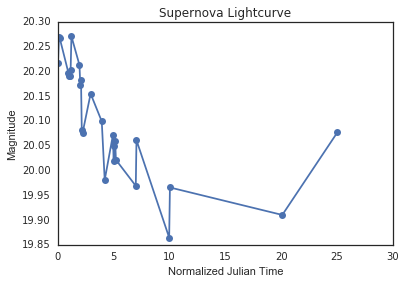

In [34]:
plt.plot(data_df['MJD'], data_df['MAG_AUTO'], marker='o')
plt.xlabel('Normalized Julian Time')
plt.ylabel('Magnitude')
plt.title('Supernova Lightcurve')
plt.savefig('paper_images/supernova_fig1.png')

In [35]:
data_df.columns

Index([u'# EPOCH', u'MJD', u'MAG_AUTO', u'MAGERR_AUTO', u'FLUX_AUTO',
       u'FLUXERR_AUTO'],
      dtype='object')

In [43]:
def return_new_sample():
    err = data_df['MAGERR_AUTO']
    err_list = []
    for er in err:
        err_list.append(np.random.normal(0,er))
    return data_df['MAG_AUTO'] + pd.Series(err_list)

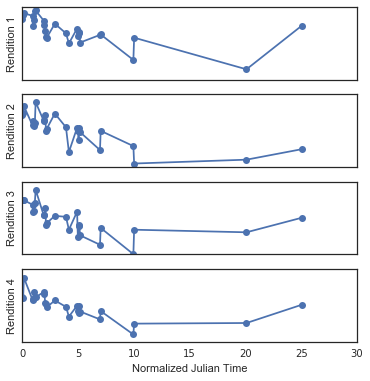

In [72]:
numplots = 4
f, axarr = plt.subplots(numplots, sharex=True, figsize=(6,6))
for i in range(numplots):
    axarr[i].plot(data_df['MJD'], return_new_sample(), marker='o')
    axarr[i].get_yaxis().set_ticks([])
    axarr[i].set_ylabel("Rendition " + str(i+1))
axarr[i].set_xlabel("Normalized Julian Time")
plt.savefig('paper_images/multiple_error_renditions.png')

In [73]:
#Data synthesization images
def basic_irregular(stopTime, numPoints, numSelPoints):
    time = np.linspace(0, stopTime, numPoints)
    data = np.sin(time)
    index = np.sort(np.random.choice(range(numPoints), size=numSelPoints, replace=False))
    time_irr = time[index]
    data_irr = data[index]
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    data_mat = np.matrix([list(data_irr), delta_t]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec

In [101]:
data_mat, resp_mat, time_vec = basic_irregular(20, 400, 80)

In [104]:
data_mat2, resp_mat2, time_vec2 = basic_irregular(20, 400, 200)

In [102]:
time = np.linspace(0, 20, 400)
data = np.sin(time)

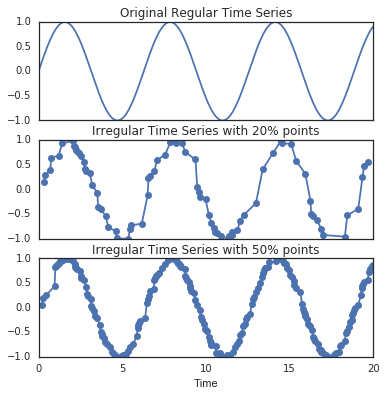

In [107]:
numplots = 3
f, axarr = plt.subplots(numplots, sharex=True, figsize=(6,6))
axarr[0].plot(time, data)
axarr[0].set_title('Original Regular Time Series')
axarr[1].plot(time_vec, data_mat[:, 0], marker='o')
axarr[1].set_title('Irregular Time Series with 20% points')
axarr[2].plot(time_vec2, data_mat2[:, 0], marker='o')
axarr[2].set_title('Irregular Time Series with 50% points')
axarr[2].set_xlabel("Time")
plt.savefig('paper_images/data_gen_sin.png')

In [108]:
def acc_vel_irregular(stopTime, numPoints, numSelPoints):
    time = np.linspace(0, stopTime, numPoints)
    data = np.sin(time)
    index = np.sort(np.random.choice(range(numPoints), size=numSelPoints, replace=False))
    time_irr = time[index]
    data_irr = data[index]
    delta_t = [0] + list(np.array(time_irr[1:]) - np.array(time_irr[:-1]))
    derivative = np.divide(np.diff(data_irr), np.diff(time_irr))
    magDerivative = np.lib.pad(derivative, (1,0), 'constant', constant_values=(0,0))
    dDerivative = np.lib.pad(np.diff(magDerivative), (1,0), 'constant', constant_values=(0,0))
    data_mat = np.matrix([list(data_irr), delta_t, list(magDerivative), list(dDerivative)]).T
    data_mat = data_mat[:-1,:]
    resp_mat = np.matrix(np.roll(data_irr, -1)[:-1]).T
    time_vec = time_irr[1:]
    return data_mat, resp_mat, time_vec

In [109]:
data_mat, resp_mat, time_vec = acc_vel_irregular(20, 400, 80)

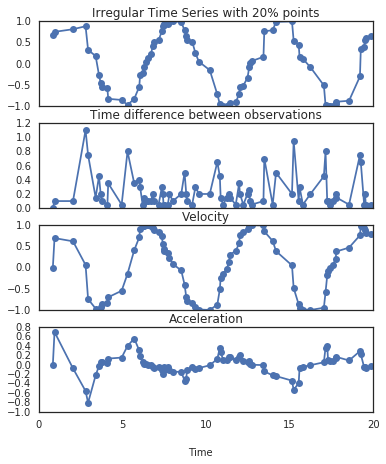

In [121]:
numplots = 4
f, axarr = plt.subplots(numplots, sharex=True, figsize=(6,7))
axarr[0].plot(time_vec, data_mat[:, 0], marker='o')
axarr[0].set_title('Irregular Time Series with 20% points')
axarr[1].plot(time_vec, data_mat[:, 1], marker='o')
axarr[1].set_title('Time difference between observations')
axarr[2].plot(time_vec, data_mat[:, 2], marker='o')
axarr[2].set_title('Velocity')
axarr[3].plot(time_vec, data_mat[:, 3], marker='o')
axarr[3].set_title('Acceleration')
f.text(0.5, 0.04, 'Time', ha='center')
plt.savefig('paper_images/features.png')

In [122]:
#LPV graph basic
datapath = os.path.join(os.getcwd(), 'data/LPV')
list_files = listdir_nohidden(datapath)

In [123]:
file_sel = list_files[0]
filepath = os.path.join(datapath, file_sel)
data = []
with open(filepath) as f:
    lines = f.readlines()
    header = [str(val) for val in lines[2].split(' ')]
    for line in lines[3:]:
        data.append([float(val) for val in line.split(' ')])
data_df = pd.DataFrame(data)
data_df.columns = header

In [124]:
data_df.columns

Index([u'#MJD', u'Mag', u'Err\n'], dtype='object')

In [125]:
data_df['#MJD'] = data_df['#MJD'] - data_df['#MJD'].loc[0]

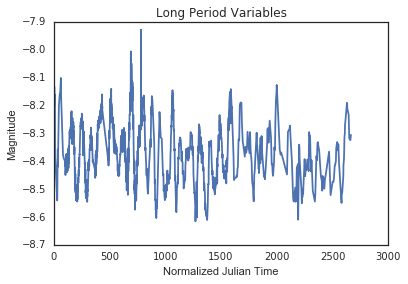

In [129]:
plt.plot(data_df['#MJD'], data_df['Mag'])
plt.xlabel('Normalized Julian Time')
plt.ylabel('Magnitude')
plt.title('Long Period Variables')
plt.savefig('paper_images/lpv_signal.png')